# QuantumBlack Hackathon - AI For Good

Binary classifier that predicts presence of methane emissions in an image. Model integrated in a Streamlit Web App for seamless workflows.

***
by: Clara Besnard, Ian Moon, Marina Pellet, Łukasz Pszenny, Adel Remadi, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers building the binary classifier to predict the presence of a methane plume in a given image.

In [ ]:
# if necessary, run installs
%pip install os pandas geopandas shapely reverse_geocoder pycountry

### 1. Import Packages

In [15]:
from importlib import reload
reload(prepData)
reload(loadData)
reload(modeling)
reload(vizData)

<module 'util.visualize_data' from 'd:\\Dokumente\\2_Bildung\\2_MSc\\1_Classes\\Y2T3_QuantumBlack AI For Good\\QB-AI-for-Good\\util\\visualize_data.py'>

In [1]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.modeling as modeling
import util.visualize_data as vizData

In [2]:
# data handling
import os
import numpy as np
from PIL import Image

# data viz
import matplotlib.pyplot as plt

In [3]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [4]:
# get transforms
transform     = prepData.get_transform() # to be applied during training
transform_viz = prepData.get_transform(visualize = True) # to visualize what transform does (without normalization)

In [5]:
# fetch metadata
trnval_metadata = loadData.load_metadata("images/metadata.csv", set = "train")
tst_metadata    = loadData.load_metadata("images/metadata.csv", set = "test")

# perform train validation split
trn_metadata, val_metadata = loadData.trainval_split(trnval_metadata, val_size = 0.2)

# show sizes of datasets
print(f"Size of trainval data: {trnval_metadata.__len__()}")
print(f"Size of training data: {trn_metadata.__len__()}")
print(f"Size of validation data: {val_metadata.__len__()}")
print(f"Size of test data: {tst_metadata.__len__()}")

Size of trainval data: 430
Size of training data: 344
Size of validation data: 86
Size of test data: 0


In [6]:
# get pytorch datasets for visualization
trn_dataset_viz_no_transform = loadData.CustomDataset(trn_metadata, apply_CLAHE = False)
trn_dataset_viz_transform    = loadData.CustomDataset(trn_metadata, transform = transform_viz, resize = True, apply_CLAHE = True)

# get pytorch datasets for modeling
trn_dataset = loadData.CustomDataset(trn_metadata, transform = transform, resize = True, apply_CLAHE = True)
val_dataset = loadData.CustomDataset(val_metadata, transform = transform, resize = True, apply_CLAHE = True)
tst_dataset = loadData.CustomDataset(tst_metadata, transform = transform, resize = True, apply_CLAHE = True)

In [7]:
# get mean and std of dataset to identify values by which we need to normalize
trn_dataset.compute_mean_std()

(60.0644191863925, 58.84460681054689)

images/no_plume/20230305_methane_mixing_ratio_id_2384.tif
images/no_plume/20230305_methane_mixing_ratio_id_2384.tif
4096
50176


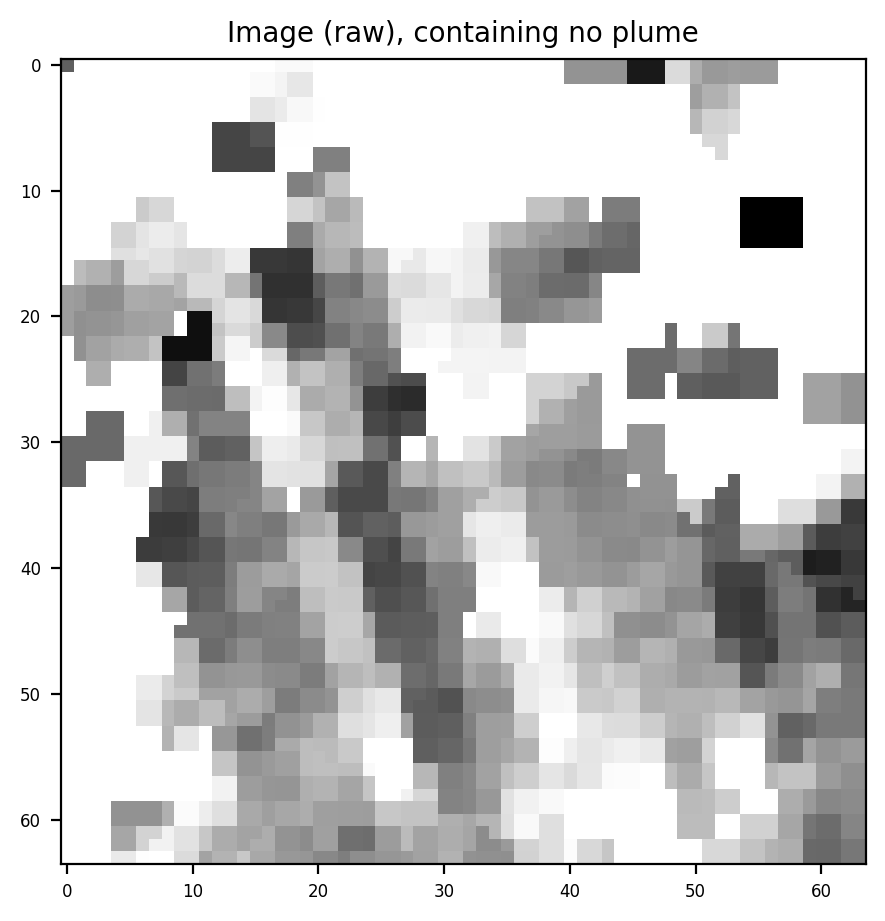

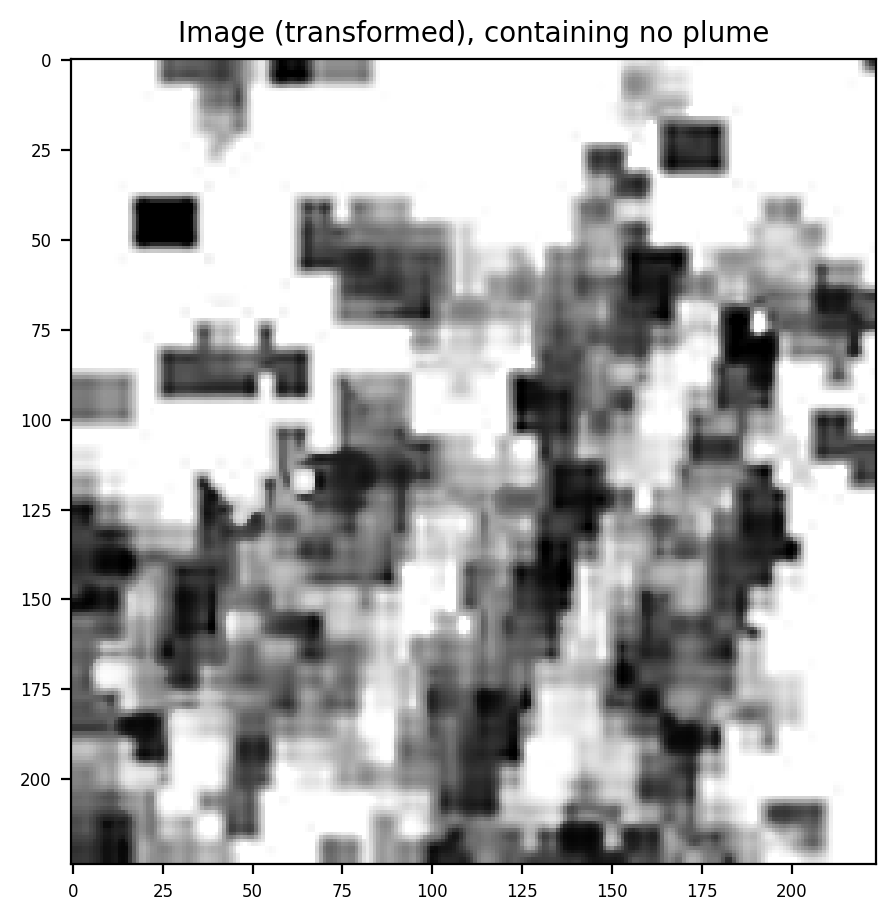

In [8]:
# fetch random image & mask for visualization (training)
idx = 5

# get non-transformed image
_, img, lbl = trn_dataset_viz_no_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# get transformed image
_, img_tf, _ = trn_dataset_viz_transform.__getitem__(idx)
path = trn_metadata.loc[idx].path
print(path)

# visualize original image (without transformations)
vizData.visualize(img, lbl = lbl)

# visualize transformed image
vizData.visualize(img_tf, lbl = lbl, transform = True)

### 3. Modeling

In [21]:
# where to save trial results to
ray_path = os.path.normpath(os.getcwd()).replace("\\", "/") +"/ray_results/"
if not os.path.isdir(ray_path):
    os.mkdir(ray_path)

# ignore warnings that show in every raytune run
import warnings
warnings.simplefilter(action = "ignore", category = np.VisibleDeprecationWarning)

In [26]:
# tunable hyperparameter search space --> search using tune.choice([]), tune.uniform(lower, upper), tune.grid_search([])
config = {
    # basic infos
    "max_epochs": tune.grid_search([10, 20, 50]),
    "batch_size": tune.grid_search([4, 8, 16]),
    "dir": os.path.normpath(os.getcwd()).replace("\\", "/"),
    "verbose": False,
    
    # model
    "model": tune.grid_search(["ResNet18", "ResNet34"]),
    "pretrained": tune.grid_search([False, True]),
    
    # scheduler
    "lr_s": "Cosine", # StepLR decreases learning rate every 10 epochs by factor of 10
    
    # optimizer
    "lr":   tune.grid_search([1e-2, 5e-3, 1e-3])
    "wd":   1e-2,
    "mom":  0.9,
    
    # loss function
    "criterion": "BCE"
}

In [27]:
# how many trials to run (if grid_search utilized, it will run this number per grid_search value)
num_samples = 1

# run experiment
result_grid = modeling.run_ray_experiment(
    modeling.ray_trainable, config, ray_path, num_samples,
    metric_columns = ["trn_acc", "val_acc", "training_iteration"],
    parameter_columns = ["batch_size", "lr_s", "lr", "wd", "mom"]
)

2023-05-13 12:44:12,332	INFO tune.py:798 -- Total run time: 41.27 seconds (41.25 seconds for the tuning loop).


**Analyze RayTune experiment.**

In [ ]:
restored_tuner, result_grid = modeling.open_validate_ray_experiment("ray_results/", modeling.ray_trainable)

In [29]:
# get best N trials in this experiment (highest validation accuracy [averaged across 4 folds])
N = 10
best_result_df = result_grid.get_dataframe(
    filter_metric="val_acc", filter_mode="max"
)
best_result_df = best_result_df[["trial_id", "training_iteration", 
                                 "config/model", "config/pretrained", "config/batch_size",
                                 "config/lr_s", "config/lr", "config/wd", "config/mom", 
                                 "trn_loss", "val_loss", "trn_acc", "val_acc"]]

best_result_df = best_result_df.sort_values(by=["val_acc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,trial_id,training_iteration,config/model,config/pretrained,config/batch_size,config/lr_s,config/lr,config/wd,config/mom,trn_loss,val_loss,trn_acc,val_acc
0,0089d_00000,18,ResNet18,False,20,Cosine,0.001,0.01,0.9,0.119449,0.616024,0.982558,0.802326
